In [1]:
# Include libraries
from ipywidgets import FloatProgress
from IPython.display import display
from warnings import simplefilter
# Stop warnings from printing
simplefilter('ignore')
import matplotlib.pyplot as plt
from copy import deepcopy
import os
import numpy as np
import cpuinfo
import sys
import math

# Load pytorch
import torch
import torchvision

In [2]:
# Check Available Devices
if torch.cuda.is_available():
    print('Using {0} GPUs:'.format(torch.cuda.device_count()))
    for i in range(torch.cuda.device_count()):
        print('GPU {0}: {1}'.format(i, torch.cuda.get_device_name(i)))
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("Using " + str(cpuinfo.get_cpu_info()['brand']))

Using 2 GPUs:
GPU 0: GeForce GTX 1070
GPU 1: GeForce GTX 1070


In [3]:
# Build a FCN from pretrained Alexnet
class VGG16FCN(torch.nn.Module):
    # Initialises the FCN
    def __init__(self, numberOfClasses):
        super().__init__()
        
        # Load pretrained VGG16 to copy parameters from
        VGG16 = torchvision.models.vgg16(pretrained = True)
        
        # Downsampling Pathway
        self.downSample1 = torch.nn.Sequential(*list(VGG16.features.children())[0:17]) # Dim / 8
        self.downSample2 = torch.nn.Sequential(*list(VGG16.features.children())[17:24]) # Dim / 16
        # Demensionality Reduction to produce a tensor for each class
        self.downSample3 = torch.nn.Sequential(
                *list(VGG16.features.children())[24:31],
                torch.nn.Conv2d(256, numberOfClasses, kernel_size = (1,1)), 
                torch.nn.ReLU(True),
                torch.nn.Dropout(p=0.5),
                torch.nn.Conv2d(256, numberOfClasses, kernel_size = (1,1)),
                torch.nn.ReLU(True),
                torch.nn.Dropout(p=0.5),
                torch.nn.Conv2d(256, numberOfClasses, kernel_size = (1,1))
        ) # Dim / 32
        
        # Upsampling Pathway - Bilinear interpolation
        self.upSample2 = torch.nn.Sequential(torch.nn.Upsample(scale_factor = 2, mode = 'bilinear'))
        self.upSample8 = torch.nn.Sequential(torch.nn.Upsample(scale_factor = 8, mode = 'bilinear'))
        self.upSample16 = torch.nn.Sequential(torch.nn.Upsample(scale_factor = 16, mode = 'bilinear'))
        self.upSample32 = torch.nn.Sequential(torch.nn.Upsample(scale_factor = 32, mode = 'bilinear'))

# Derived Network versions
class VGG16FCN8(VGG16FCN):                                     
    # Forward path through the network
    def forward(self, inputTensor):
        # Downsampling Pathway
        output1 = self.downSample1(inputTensor)
        output2 = self.downSample2(output1)
        output3 = self.downSample3(output2)
        # Upsampling Pathway
        output16 = self.upSample2(output3) + output2
        output8 = self.upSample2(output16) + output1
        return self.upSample8(output8)
    
class VGG16FCN16(VGG16FCN):                                     
    # Forward path through the network
    def forward(self, inputTensor):
        # Downsampling Pathway
        output1 = self.downSample1(inputTensor)
        output1 = self.downSample2(output1)
        output2 = self.downSample3(output1)
        # Upsampling Pathway
        output = self.upSample2(output2) + output1
        return self.upSample16(output)
    
class VGG16FCN32(VGG16FCN):                                     
    # Forward path through the network
    def forward(self, inputTensor):
        # Downsampling Pathway
        output1 = self.downSample1(inputTensor)
        output1 = self.downSample2(output1)
        output1 = self.downSample3(output1)
        # Upsampling Pathway
        return self.upSample32(output1)

In [4]:
# Instance a FCN base on AlexNet
VGG16FCN8 = VGG16FCN8(2)

In [5]:
# Check the network has been modified
print(VGG16FCN8)

VGG16FCN8(
  (downSample1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

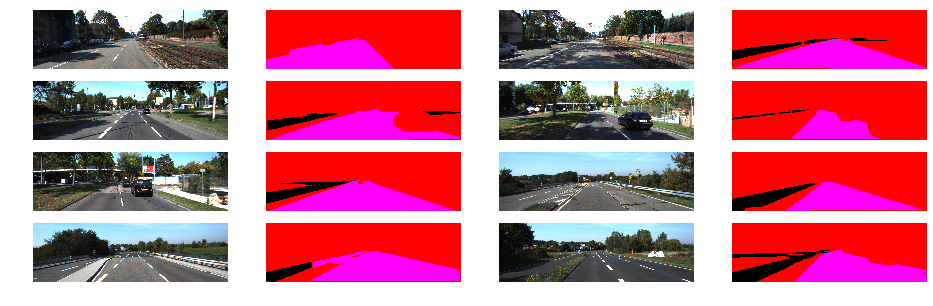

In [6]:
# Get current working directory
path =  os.getcwd() + "\Data\data_road"
pathRaw = path + "\\training\\raw\\image_2"
pathGroundTruth = path + "\\training\\gt\\gt_image_2"
groundTruthFiles = os.listdir(pathGroundTruth)
rawFiles = os.listdir(pathRaw)

# Print examples of the images
Figure = plt.figure(figsize=(16, 5))
for i in range(16):
    if (i % 2 != 0):
        tmpFilePath = pathGroundTruth + "\\" + groundTruthFiles[i]
    else:
        tmpFilePath = pathRaw + "\\" + rawFiles[i]
    
    tmpImage = plt.imread(tmpFilePath)
    Figure.add_subplot(4, 4, i+1).axis('off')
    plt.imshow(tmpImage)

In [11]:
# Get current working directory
path =  os.getcwd() + '\\Data\\data_road'
pathRaw = path + '\\training\\raw\\'
pathGroundTruth = path + '\\training\\gt\\'

# Split images into training and validation randomly
indicies = list(range(len(os.listdir(pathRaw))))
splitSize = math.ceil(len(os.listdir(pathRaw))*0.2) # Validation set size as percentage
valiIndices = np.random.choice(indicies, size = splitSize, replace = False)
trainIndices = list(set(indicies) - set(valiIndices))

# Create pytorch samplers using the generated indexs
trainingSampler = torch.utils.data.SequentialSampler(trainIndices)
valiSampler = torch.utils.data.SequentialSampler(valiIndices)
# Using sequential sampler to hopefully get raw and groundtruth image pairs
# from two different loaders

# Import some ojects from pytorch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
# Define a list to store batch image loaders
# settings for different phases
imageLoaders = {'train': DataLoader(ImageFolder(root = pathRaw, transform = transforms.ToTensor()),
                        batch_size = 24, num_workers = 4),
                
                'trainLabled': DataLoader(ImageFolder(root = pathGroundTruth, transform = transforms.ToTensor()),
                               batch_size = 24, num_workers = 4),
                
                'vali': DataLoader(ImageFolder(root = pathRaw, transform = transforms.ToTensor()),
                        batch_size = 24, sampler = trainingSampler, num_workers = 4),
                
                'valiLabled': DataLoader(ImageFolder(root = pathGroundTruth, transform = transforms.ToTensor()),
                              batch_size = 24, sampler = trainingSampler, num_workers = 4),
                
                'test': DataLoader(ImageFolder(root = pathGroundTruth, transform = transforms.ToTensor()),
                        batch_size = 24, sampler = trainingSampler, num_workers = 4)
               }


In [26]:
# Utility function to convert tensor stack to RGB colour image
from torchvision import utils
def tensorToNumpy(imageTensor):
    grid = utils.make_grid(imageTensor)
    grid = grid.numpy().transpose((1, 2, 0))
    # clip any values less than 0 or greater than 1 to
    # avoid the wrath of matplotlib
    grid = np.clip(grid, 0, 1)
    return grid

0 torch.Size([24, 3, 375, 1242])
0 torch.Size([24, 3, 375, 1242])
1 torch.Size([24, 3, 375, 1242])
1 torch.Size([24, 3, 375, 1242])


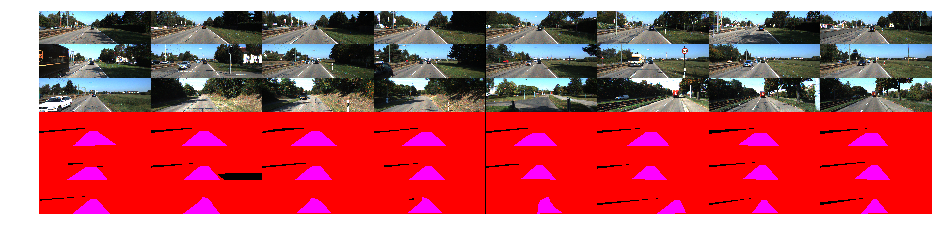

In [53]:
# Confirming that sequential loaders are working
for batch, gtrawBatched in enumerate(zip(imageLoaders['train'], imageLoaders['trainLabled'])):
    print(batch, gtrawBatched[0][0].shape)
    print(batch, gtrawBatched[1][0].shape)
    # generate 2nd batch and display it
    if batch == 1:
        plt.figure(figsize=(16, 14))
        img = tensorToNumpy(torch.cat((gtrawBatched[0][0], gtrawBatched[1][0])))
        plt.axis('off')
        plt.imshow(img)
        plt.savefig('Figures\\BatchExample.png')
        break 